## Install MMSegmentation

https://mmsegmentation.readthedocs.io/en/latest/get_started.html#installation

(install from source not pip)

We use PyTorch 1.10 and CUDA 11.1 for this tutorial. You may install other versions by change the version number in pip install command. 

In [ ]:
%cd mmsegmentation

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
import mmcv
print(mmseg.__version__)

#### CPU training

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# and/or
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## CRACKS_AND_POTHOLES DATASET PREPROCESS

### download and unzip

In [1]:
!git clone https://github.com/biankatpas/Cracks-and-Potholes-in-Road-Images-Dataset.git lane

Cloning into 'lane'...
remote: Enumerating objects: 9261, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 9261 (delta 13), reused 7 (delta 0), pack-reused 9232
Receiving objects: 100% (9261/9261), 220.71 MiB | 1.57 MiB/s, done.
Resolving deltas: 100% (577/577), done.
Checking out files: 100% (8952/8952), done.


### Modify dataset

In [1]:
import os
import os.path as osp
import numpy as np
from PIL import Image
import mmcv


data_root = 'lane'
# data_root = 'cracks'

data = 'Dataset'

classes = ('background', 'lane') #, 'lane')
palette = [[127,127,127], [70, 255, 0]] #, [70, 255, 0]]

# classes = ('background', 'crack')
# palette = [[127,127,127], [255, 70, 0]]

In [2]:
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = os.listdir(osp.join(data_root, data))

### split train/val set randomly into split txt files

In [3]:
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 80% as train set
  train_length = int(len(filename_list)*8/10)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 20% as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

### remove unessessary folder stracture

In [4]:
for folder in filename_list:
    for file in  os.listdir(os.path.join(data_root, data, folder)):
        os.rename(os.path.join(data_root, data, folder, file), os.path.join(data_root, data, file))
    os.rmdir(os.path.join(data_root, data, folder))

### modify masks for mmseg compatability

In [5]:
filename_list[0:5]

['919730_RS_290_290RS294095_32100',
 '919702_RS_290_290RS294095_31960',
 '1092109_DF_251_251BDF0490_01519',
 '1014706_RS_386_386RS124739_30455',
 '1083821_DF_080_080BDF0090_00423']

In [6]:
extensions = ['_LANE.png'] #, '_LANE.png']
# extensions = ['_CRACK.png']

for file in filename_list:
    
    #set dimensions to shape of a mask
    multiclass_mask = np.zeros(np.asarray(Image.open(osp.join(data_root, data, file + extensions[0]))).shape[:2])
    
    for i, c in enumerate(extensions):
            
        im = Image.open(osp.join(data_root, data, file + c))
        
        # convert to binary
        im = im.convert('L').convert('1')
        mask_array = np.asarray(im)
        
        # write to combined mask
        multiclass_mask[mask_array] = i+1

    
    multiclass_img = Image.fromarray(multiclass_mask).convert('P')
    multiclass_img.putpalette(np.array(palette, dtype=np.uint8))

    multiclass_img.save(osp.join(data_root, data, file + '_LABELS.png'))

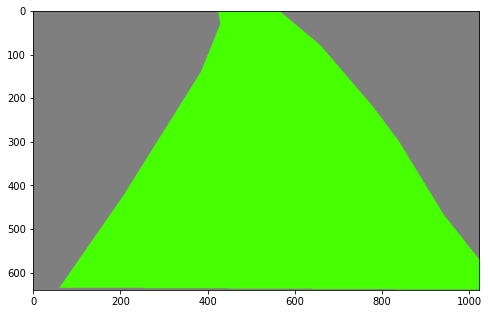

In [7]:
# Let's take a look at the dataset
import matplotlib.pyplot as plt

img = mmcv.imread('lane/Dataset/1007599_RS_386_386RS289112_28920_LABELS.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

### calculate averages

In [8]:
from PIL import Image

means =  np.empty((0,3), float)
stds =  np.empty((0,3), float)

for file in mmcv.scandir(osp.join(data_root, data), suffix='_RAW.jpg'):
    im = Image.open(osp.join(data_root, data, file))
    im = np.asarray(im)
    mean = np.mean(im, axis=(0,1))
    std = np.std(im, axis=(0,1))
    means = np.append(means, np.expand_dims(mean, 0), axis=0)
    stds = np.append(stds, np.expand_dims(std, 0), axis=0)

print(means.shape)
mean_total = np.sum(means, 0)/means.shape[0]
std_total = np.sum(stds, 0)/stds.shape[0]
print("mean ", mean_total)
print("std ", std_total)

(2235, 3)
mean  [125.45255196 123.62743243 121.7754468 ]
std  [28.85059238 25.90989769 25.39601423]


In [ ]:
mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375] #old
mean=[125.45, 123.62, 121.77], std=[28.85, 25.91, 25.39] # cracks (with val)

### dataset registration

Registering new dataset class and implementing `load_annotations` function.

For non-temporary registration, add it in: 'mmseg/datasets/cracks_and_potholes_dataset.py'
and modify  'mmseg/datasets/__init__.py'

In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class CracksAndPotholesDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='_RAW.jpg', seg_map_suffix='_LABELS.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir)
    assert self.split is not None
    

## POTHOLES600 DATASET PREPROCESS

Link to dataset: https://sites.google.com/view/pothole-600/dataset

make a clean copy of pothole600 dataset into mmsegmentation root

### Modify dataset

In [54]:
import os
import os.path as osp
import shutil
import numpy as np
from PIL import Image
import mmcv


data_root = 'pothole600_ogsplit/'

#original
training_data = 'training/rgb'
training_labels = 'training/label'

validation_data = 'validation/rgb'
validation_labels = 'validation/label'

testing_data = 'testing/rgb'
testing_labels = 'testing/label'

#mmsegmentation stracture 
# https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md
mm_training_data = 'img_dir/train' 
mm_training_labels = 'ann_dir/train'

mm_validation_data = 'img_dir/val'
mm_validation_labels = 'ann_dir/val'

mm_testing_data = 'img_dir/test'
mm_testing_labels = 'ann_dir/test'


classes = ('background', 'pothole') #, 'lane')
palette = [[127,127,127], [70, 255, 0]] #, [70, 255, 0]]


### rearrange folders

In [55]:
shutil.move(data_root+training_data, data_root+mm_training_data)
shutil.move(data_root+training_labels, data_root+mm_training_labels)
shutil.move(data_root+validation_data, data_root+mm_validation_data)
shutil.move(data_root+validation_labels, data_root+mm_validation_labels)
shutil.move(data_root+testing_data, data_root+mm_testing_data)
shutil.move(data_root+testing_labels, data_root+mm_testing_labels)

'pothole600_ogsplit/ann_dir/test'

### modify masks for mmseg compatability

In [56]:
annotations = [data_root+mm_training_labels, data_root+mm_validation_labels, data_root+mm_testing_labels]

for ann_set in annotations:
    for file in os.listdir(ann_set):

        im = Image.open(osp.join(ann_set, file))

        # convert to binary
        im = im.convert('L').convert('1')
        mask_array = np.asarray(im)

        img = Image.fromarray(mask_array).convert('P')
        img.putpalette(np.array(palette, dtype=np.uint8))

        img.save(osp.join(ann_set,file))

In [57]:
# Let's take a look at the dataset
import matplotlib.pyplot as plt

img = mmcv.imread(im)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

TypeError: "img" must be a numpy array or a str or a pathlib.Path object

dataset has been split to 240/180/180. Manually transfer the desired photos to desired folders. 

all test-->  train
60 from val --> train

480/120

In [29]:
train_len = len(os.listdir(data_root+mm_training_data))


for i, file in enumerate(os.listdir(data_root+mm_testing_data)):
        os.rename(os.path.join(data_root+mm_testing_data, file),
                  os.path.join(data_root+mm_training_data, str(train_len+i).zfill(4) +'.png'))
        
for i, file in enumerate(os.listdir(data_root+mm_testing_labels)):
        os.rename(os.path.join(data_root+mm_testing_labels, file),
                  os.path.join(data_root+mm_training_labels, str(train_len+i).zfill(4) +'.png'))
        
        
train_len = len(os.listdir(data_root+mm_training_data))

for i, file in enumerate(os.listdir(data_root+mm_validation_data)[120:]):
        os.rename(os.path.join(data_root+mm_validation_data, file),
                  os.path.join(data_root+mm_training_data, str(train_len+i).zfill(4) +'.png'))
        
for i, file in enumerate(os.listdir(data_root+mm_validation_labels)[120:]):
        os.rename(os.path.join(data_root+mm_validation_labels, file),
                  os.path.join(data_root+mm_training_labels, str(train_len+i).zfill(4) +'.png'))

os.rmdir(data_root+mm_testing_labels)
os.rmdir(data_root+mm_testing_data)

FileNotFoundError: [Errno 2] No such file or directory: 'pothole600/img_dir/test'

In [30]:
len(os.listdir(data_root+mm_training_data))

480

### dataset registration

Registering new dataset class and implementing `load_annotations` function.

For non-temporary registration, add it in: 'mmseg/datasets/cracks_and_potholes_dataset.py'
and modify  'mmseg/datasets/__init__.py'

In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class Potohole600Dataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir)
    assert self.split is not None
    